# 导入所有的模块，进行仿真

## import所需要的库以及必要的模块

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from Model.Static_Model.Static_Electrolyzer_Model_Hyzenis import AWE_Electrolyzer_Static
from Model.Dynamic_models.Dynamic_Model_Thermal import AWE_Electrolyzer_Dynamic
from Modules.Feedforward_PID  import Feedforward_PID_Controller
from Simulation_Platform.Platform import Simulation_Platform
from keys import Cols

## 将风光发电实例数据集转换为dataframe格式，提取其中的功率序列并将其转换为电流输入。

### 第一种建立电流输入的方法：手动创建numpy数组(方便创建阶梯、锯齿等规律波形)

In [2]:
cd01 = np.repeat(3000, 3000)
cd02 = np.repeat(2000, 3000)
cd03 = np.repeat(4000, 3000)
cd04 = np.repeat(3000, 3000)
current_density_data = np.concatenate((cd01, cd02, cd03, cd04))

### 第二种建立电流输入的方法：读取csv文件为dataframe格式

In [3]:
df = pd.read_excel("C://Users//Orz//Desktop//电解系统控制//dataset//Wind farm site 1 (Nominal capacity-99MW).xlsx")
df.head(3)

,Time(year-month-day h:m:s),Wind speed at height of 10 meters (m/s),Wind direction at height of 10 meters (˚),Wind speed at height of 30 meters (m/s),Wind direction at height of 30 meters (˚),Wind speed at height of 50 meters (m/s),Wind direction at height of 50 meters (˚),Wind speed - at the height of wheel hub(m/s),Wind speed - at the height of wheel hub (˚),Air temperature (°C),Atmosphere (hpa),Relative humidity (%),Power (MW)
0,2019-01-01 00:00:00,2.209,81.317,1.991,74.814,2.094,77.667,2.494,74.500,-13.484,889.867,76.320,0.254383
1,2019-01-01 00:15:00,1.828,77.460,1.698,75.048,1.757,88.733,1.882,74.367,-13.691,889.575,76.757,0.329703
2,2019-01-01 00:30:00,2.193,86.700,2.313,84.688,2.344,89.100,2.350,NaN,-13.766,889.942,76.981,0.296306


提取功率序列，并将其换算为电流输入

In [4]:
power_data = df['Power (MW)'].values
current_density_data = (power_data * 60 + 4000) / 2

### 画出输入电密随时间的变化

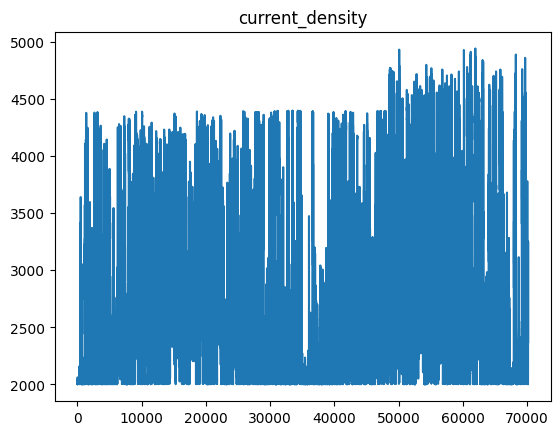

In [5]:
time = np.arange(stop = current_density_data.size)
plt.plot(time, current_density_data)
plt.title('current_density')
plt.show()

## 创建电解槽实例

### 创建电解槽稳态模型实例

In [ ]:
awe_static_model = AWE_Electrolyzer_Static()

### 创建电解槽动态模型实例

In [ ]:
awe_dynamic_model = AWE_Electrolyzer_Dynamic()

### 创建电解槽运行状态dataframe

In [ ]:
awe_state_df = pd.DataFrame(columns=[Cols.current_density, Cols.voltage, Cols.lye_flow, Cols.lye_temp, Cols.temp_out, Cols.pressure, Cols.temp_environment])

## 创建控制器实例
(本次调试使用前馈PID控制方法)

In [ ]:
Kp = -0.02  # 小->大
Ki = 0.00001  # 先0 消除最终误差
Kd = 0
integral_min = -500 # 积分下限
integral_max = 500 # 积分上限

feedforward_pid_controller = Feedforward_PID_Controller(
    Kd=Kd,
    Kp=Kp,
    Ki=Ki,
    integral_min = integral_min,
    integral_max = integral_max
)


## 创建仿真平台实例，并将相关实例赋给平台

In [ ]:
time_step = 1.0  # 时间步长 s
total_time = current_density_data.size  # 总仿真时间 s

platform = Simulation_Platform(awe_static_model=awe_static_model,
                               awe_dynamic_model=awe_dynamic_model,
                               awe_state_df=awe_state_df,
                               controller=feedforward_pid_controller,
                               time_step=10,
                               total_time=86400)


## 运行仿真，记录温度变化过程并打印

In [9]:
platform.load_current_data(current_density_data)
platform.run_simulation()

temperature_history = platform.get_results()
setpoint_history = platform.setpoint_history
print("Temperature history:", temperature_history)

Simulation completed.
Temperature history: [333.01070491 333.02142147 333.03212495 ... 354.70960482 354.70642905
 354.70318237]


## 画出温度变化图

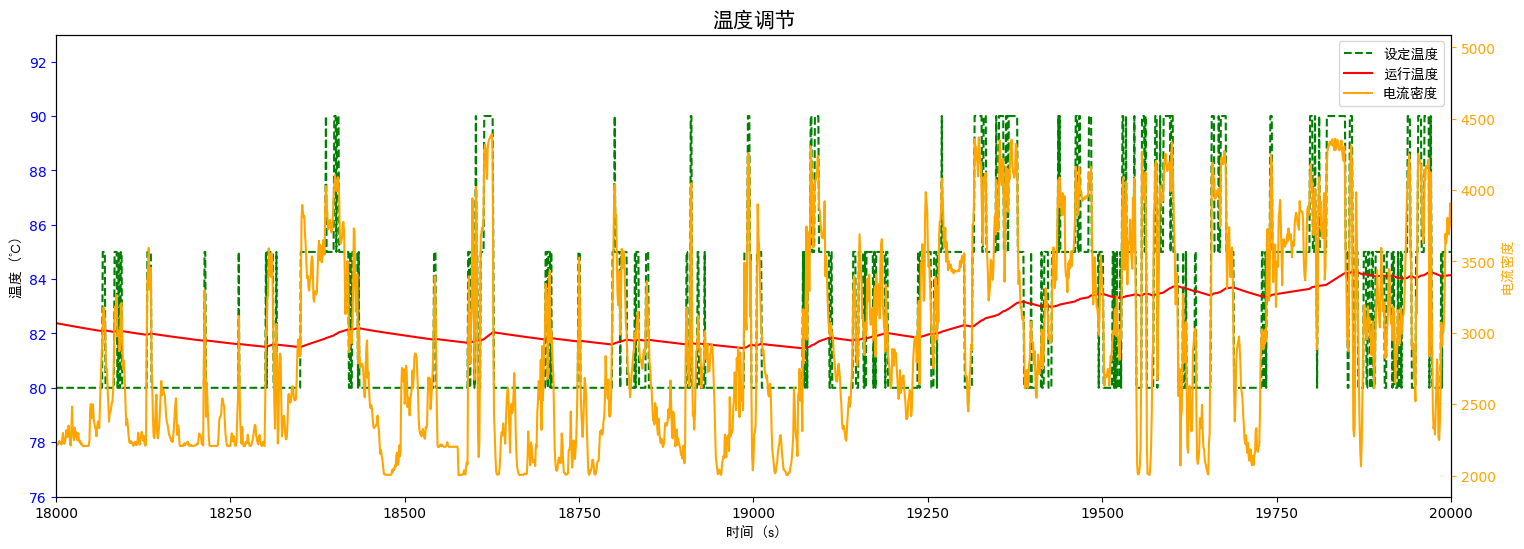

In [31]:
# 设置中文字体
font_path = 'C:/Windows/Fonts/simhei.ttf'  # 替换为你系统中支持中文的字体路径，这里以黑体为例
prop = fm.FontProperties(fname=font_path)

minus = np.repeat(273, len(setpoint_history))

time_array = np.arange(1, total_time + 1)

# 创建图表和子图
fig, ax1 = plt.subplots(figsize=(18, 6))
plt.title('温度调节', fontproperties=prop, fontsize = 15)

# 绘制第一个因变量的曲线
ax1.plot(time_array, setpoint_history - minus, linestyle = '--', c = 'g', label = '设定温度')
ax1.plot(time_array, temperature_history - minus, c = 'r', label = '运行温度')
ax1.set_xlabel("时间 (s)", fontproperties=prop)
ax1.set_ylabel("温度 (℃)", fontproperties=prop)
ax1.set_ylim(76, 93)
ax1.tick_params('y', colors='b')

# 创建第二个y轴
ax2 = ax1.twinx()

# 绘制第二个因变量的曲线
ax2.plot(time_array, current_density_data, c = 'orange', label = '电流密度')
ax2.set_ylabel('电流密度', color='orange', fontproperties=prop)
ax2.tick_params('y', colors='orange')

plt.xlim(18000, 20000)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines + lines2, labels + labels2, loc='upper right', prop=prop)
plt.show()